In [57]:
import numpy as np
import scipy.linalg as la
from sklearn.linear_model import Lasso, LinearRegression
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

## Plain Algorithm 

In [58]:
def sign(x):
    """
    If x is nonzero, return x/|x|, else return 0
    """
    if x>0:
        return 1
    if x<0:
        return -1
    if x==0:
        return 0

def pos(x):
    """
    Return maximum between x and 0
    """
    return max(x, 0)

def BIC(x, Y, lambd, var_ols):
    """
    Compute BIC of certain penalty paramter choices
    """
    N = Y.shape[0]
    LASSO = Lasso(alpha=lambd, fit_intercept=False, normalize=False).fit(x, Y)
    Y_hat = LASSO.predict(x)
    df = sum(LASSO.coef_ != 0)
    err = sum((Y_hat - Y) ** 2)
    return err/(var_ols*N) + np.log(N)*df/N

def find_lambda(X, u, w_2):
    """
    Find the lambda with minimal BIC
    """
    n = X.shape[0]
    d = X.shape[1]
    Y = X.ravel("F")
    x = np.kron(np.eye(d), u.reshape(-1, 1))/w_2
    Y_ols = LinearRegression(fit_intercept=False).fit(x, Y).predict(x)
    var_ols = ((Y-Y_ols)**2).mean()
    # find approximate range of minimum 
    lambdas = np.exp(np.linspace(3, 3.5, 50))
    BICS = list(map(lambda lambd: BIC(x, Y, lambd, var_ols), lambdas))
    index = np.argmin(BICS)
    # precise search
    s_lambdas = np.exp(np.linspace(np.log(lambdas[index-1]), np.log(lambdas[index+1]), 100))
    s_BICS = list(map(lambda lambd: BIC(x, Y, lambd, var_ols), s_lambdas))
    return s_lambdas[np.argmin(s_BICS)]

def ssvd(X, gamma_1 = 2, gamma_2 = 2, tol=1e-10, iters=10000):
    """
    Sparse SVD algorithm
    """
    # shapes of X
    n = X.shape[0]
    d = X.shape[1]
    # find starting vectors
    U, S, V = la.svd(X)
    u_old = U[:, 0]
    v_old = V[0, :]
    for i in range(iters):
        # update v
        v_sim = np.zeros(d) ## v_sim initialization
        v_sh = X.T @ u_old ## v with sim and hat
        w_2 = np.vectorize(lambda x: 0 if x==0 else x**(-gamma_2))(abs(v_sh)) ## find w_2
        lambda_v = find_lambda(X, u_old, w_2)
        for j in range(d): ## LASSO
            v_sim[j] = sign(v_sh[j])*pos(abs(v_sh[j])-lambda_v*w_2[j]/2)
        v_new = v_sim / la.norm(v_sim) ## normalization
        # update u
        u_sim = np.zeros(n) ## v_sim initialization
        u_sh = X @ v_new ## v with sim and hat
        w_1 = np.vectorize(lambda x: 0 if x==0 else x**(-gamma_1))(abs(u_sh)) ## find w_1
        lambda_u = find_lambda(X.T, v_new, w_1)
        for j in range(n): ## LASSO
            u_sim[j] = sign(u_sh[j])*pos(abs(u_sh[j])-lambda_u*w_1[j]/2)
        u_new = u_sim / la.norm(u_sim) ## normalization
        # check convergence
        if la.norm(u_new - u_old)<tol and la.norm(v_new - v_old)<tol:
            break
        else:
            u_old = u_new
            v_old = v_new
    return u_new, v_new, u_new.T @ X @ v_new

## Optimized Algorithm

Starting from the plain sparse SVD algorithm, we finished two types of modification:

1. The original algorithm updates each element of $v_{new}$ and $u_{new}$, the modified version vectorized this process.

2. When finding the penalty paramter $\lambda_u$ and $\lambda_v$, the plain version conducted a rough search followed by a precise search. However, when implementing this algorithm, we found that the rough search is enough for it to find the appropriate $\lambda$. So we deleted the precise search procedure, which improved the speed a lot but did not change the accuracy.

In [59]:
def sign_new(x):
    """
    vectorized version of finding signals
    """
    y = x.copy()
    y[y!=0] = y[y!=0]/abs(y[y!=0])
    return y

def pos_new(x):
    """
    vectorized version of finding max(x, 0)
    """
    y = x.copy()
    y[y<0] = 0
    return y

def BIC_new(x, Y, lambd, var_ols):
    """
    vectorized version of computing BIC
    """
    N = Y.shape[0]
    beta_ols = la.inv(x.T@x) @ x.T @ Y
    beta_lasso = beta_ols * pos_new(1-lambd/beta_ols)
    Y_hat = x @ beta_lasso
    df = sum(beta_lasso != 0)
    err = sum((Y_hat - Y) ** 2)
    return err/(var_ols*N) + np.log(N)*df/N

def find_lambda_new(X, u, w_2):
    """
    vectorized version of finding lambda without precise search
    """
    n = X.shape[0]
    d = X.shape[1]
    Y = X.ravel("F")
    x = np.kron(np.eye(d), u.reshape(-1, 1))/w_2
    Y_ols = x @ la.inv(x.T @ x) @ x.T @ Y
    var_ols = ((Y-Y_ols)**2).mean()
    
    lambdas = np.exp(np.linspace(3, 3.5, 50))
    BICS = list(map(lambda lambd: BIC(x, Y, lambd, var_ols), lambdas))
    return lambdas[np.argmin(BICS)]

def ssvd_new(X, gamma_1 = 2, gamma_2 = 2, tol=1e-10, iters=10000):
    """
    vectorized version of sparse SVD algorithm
    """
    # shapes of X
    n = X.shape[0]
    d = X.shape[1]
    # find starting vectors
    U, S, V = la.svd(X)
    u_old = U[:, 0]
    v_old = V[0, :]
    for i in range(iters):
        # update v
        v_sim = np.zeros(d) ## v_sim initialization
        v_sh = X.T @ u_old ## v with sim and hat
        w_2 = np.vectorize(lambda x: 0 if x==0 else x**(-gamma_2))(abs(v_sh)) ## find w_2
        lambda_v = find_lambda_new(X, u_old, w_2)
        v_sim = sign_new(v_sh)*pos_new(abs(v_sh)-lambda_v*w_2/2)
        v_new = v_sim / la.norm(v_sim) ## normalization
        # update u
        u_sim = np.zeros(n) ## v_sim initialization
        u_sh = X @ v_new ## v with sim and hat
        w_1 = np.vectorize(lambda x: 0 if x==0 else x**(-gamma_1))(abs(u_sh)) ## find w_1
        lambda_u = find_lambda_new(X.T, v_new, w_1)
        u_sim = sign_new(u_sh)*pos_new(abs(u_sh)-lambda_u*w_1/2)
        u_new = u_sim / la.norm(u_sim) ## normalization
        # check convergence
        if la.norm(u_new - u_old)<tol and la.norm(v_new - v_old)<tol:
            break
        else:
            u_old = u_new
            v_old = v_new
    return u_new, v_new, u_new.T @ X @ v_new

### Speed Comparison

In [99]:
u = np.array([10, 9, 8, 7, 6, 5, 4, 3]+[2]*17+[0]*75).reshape(-1, 1)
u = u / la.norm(u)
v = np.array([10, -10, 8, -8, 5, -5]+[3]*5+[-3]*5+[0]*34).reshape(1, -1)
v = v / la.norm(v)
X1_ = 50 * u @ v

In [61]:
%timeit -n3 -r3 X1 = X1_ + np.random.normal(size=(100, 50)); ssvd(X1)

10.7 s ± 376 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [62]:
%timeit -n3 -r3 X1 = X1_ + np.random.normal(size=(100, 50)); ssvd_new(X1)

5.84 s ± 180 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


## Applications to simulated datasets

In this section, we report two simulated study of sparse SVD. For both part, we set $\gamma_1=\gamma_2=2$ and update $\lambda_u$ and $\lambda_v$ in each step with respect to BIC.

### Case 1: rank-1 matrix approximation

Consider a one-rank true signal matrix $X^*=suv^T$ with

$\tilde{u}=[10, 9, 8, 7, 6, 5, 4, 3, r(2, 17), r(0, 75)]^T, u=\tilde{u}/||\tilde{u}||$,

$\tilde{v}=[10, −10, 8, −8, 5, −5, r(3, 5), r(−3, 5), r(0, 34)]^T, v=\tilde{v}/||\tilde{v}||$,

$s=50$

A data matrix $X$ is randomly created by adding $X^*$ and a noise matrix $\epsilon$, where each element is independently generated from standard normal distribution. This process is repeated 100 times. We mainly assessed the model's accuracy of distinguishing zero and nonzero entity in $u$ and $v$.

In [100]:
num_zeros_u = []
cor_zeros_u = []
cor_non_zeros_u = []
mis_rate_u = []
num_zeros_v = []
cor_zeros_v = []
cor_non_zeros_v = []
mis_rate_v = []

np.random.seed(seed=0)
start = time()
iters = 100
with tqdm(total=iters) as pbar:
    for i in range(iters):
        X1 = X1_ + np.random.normal(size=(100, 50))
        u_new, v_new, s_new = ssvd_new(X1)
        
        num_zeros_u.append((u_new==0).sum())
        cor_zeros_u.append(np.logical_and(u_new.reshape(-1, 1)==0, u==0).sum()/75)
        cor_non_zeros_u.append(np.logical_and(u_new.reshape(-1, 1)!=0, u!=0).sum()/25)
        mis_rate_u.append(np.logical_xor(u_new.reshape(-1, 1)==0, u==0).sum()/100)
        
        num_zeros_v.append((v_new==0).sum())
        cor_zeros_v.append(np.logical_and(v_new.reshape(1, -1)==0, v==0).sum()/34)
        cor_non_zeros_v.append(np.logical_and(v_new.reshape(1, -1)!=0, v!=0).sum()/16)
        mis_rate_v.append(np.logical_xor(v_new.reshape(1, -1)==0, v==0).sum()/50)
        
        pbar.update(1)

print("Cost time: {:.2f}s per loop\n".format((time()-start)/iters))

avg = lambda x: sum(x)/iters

print("Number of zeros in u:", avg(num_zeros_u))
print("Correctly Labeled zero in u:", avg(cor_zeros_u))
print("Correctly Labeled non-zero in u:", avg(cor_non_zeros_u))
print("Misspecification in u:", avg(mis_rate_u), "\n")

print("Number of zeros in v:", avg(num_zeros_v))
print("Correctly Labeled zero in v:", avg(cor_zeros_v))
print("Correctly Labeled non-zero in v:", avg(cor_non_zeros_v))
print("Misspecification in v:", avg(mis_rate_v), "\n")

100%|██████████| 100/100 [12:06<00:00,  8.12s/it]

Cost time: 7.26s per loop

Number of zeros in u: 72.87
Correctly Labeled zero in u: 0.9705333333333331
Correctly Labeled non-zero in u: 0.9967999999999999
Misspecification in u: 0.0229 

Number of zeros in v: 32.8
Correctly Labeled zero in v: 0.9647058823529397
Correctly Labeled non-zero in v: 1.0
Misspecification in v: 0.024000000000000018 



SSVD performs pretty well in this rank-1 case. For example, in terms of correctly identifying the true zero and nonzero entries, on average it only misclassifies 1.5% and 1.0% of the entries in u and v, respectively.

### Case 2: rank-2 matrix approximation

Consider a true signal matrix $X^*$ with shape $50\times100$, where each element $X^*_{ij}=T_{ij}I_{(|T_{ij}|>1)}$ with

$$
T_{ij}=\begin{equation}
\left\{
\begin{array}{lr}
[26^2-(i-25)^2-(j-50)^2]/100 &\text{if } 26\leq j\leq 75\\
0 &\text{otherwise}
\end{array}
\right.
\end{equation}
$$

$X^*$ is almost rank-2 in that its eigenvalues are almost zero except the first two. The figure below shows the structure of $X^*$, where the positive entries are red, the negative ones are blue, and the zeros are white.

A data matrix $X$ is randomly created by adding $X^*$ and a noise matrix $\epsilon$, where each element is independently generated from standard normal distribution. This process is repeated 100 times. We mainly assessed the model's accuracy of distinguishing zero and nonzero entity in $u$ and $v$ as well as the distance of fitted matrix to the original matrix as the number of layers increases.

In [91]:
X2_ = np.zeros(shape=(50, 100))
for i in range(50):
    for j in range(25, 75):
        T = (24**2-(i-24)**2-(j-49)**2)/100
        if abs(T) > 1:
            X2_[i, j] = T

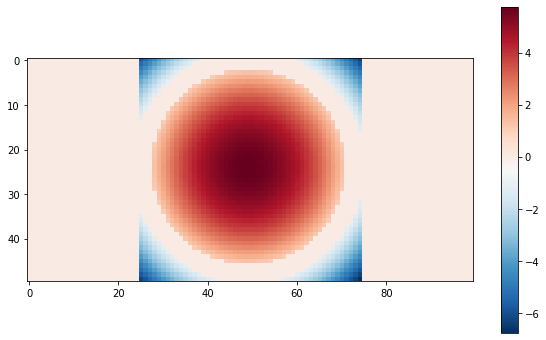

In [180]:
plt.figure(figsize=(10, 6))
plt.imshow(X2_, cmap='RdBu_r')
plt.colorbar()
plt.savefig('rank-2-true-signal.jpg')

In [98]:
def ssvd_approx(X, layer=1):
    residual = X
    X_fit = np.zeros(X.shape)
    acc = []
    f_dist = []
    for i in range(layer):
        u_new, v_new, s = ssvd_new(residual)
        X_fit += s * u_new.reshape(-1, 1) @ v_new.reshape(1, -1)
        residual = X - X_fit
        acc.append(1 - np.logical_xor(X_fit == 0, X2_ == 0).sum()/(X.shape[0]*X.shape[1]))
        f_dist.append(np.sqrt(((X2_ - X_fit)**2).sum()))
    return X_fit, acc, f_dist

In [116]:
np.random.seed(1)
X2 = X2_ + np.random.normal(size=(50, 100))
X_fit, acc, f_dist = ssvd_approx(X2, layer=10)

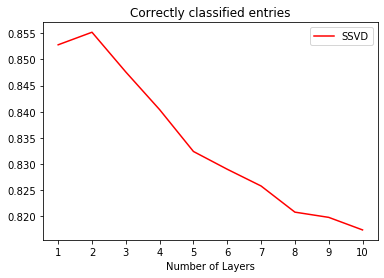

In [188]:
plt.plot(range(1, 11), acc, color='red', label='SSVD')
plt.legend()
plt.title('Correctly classified entries')
plt.xlabel('Number of Layers')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.savefig('acc-ssvd.jpg')
plt.show()

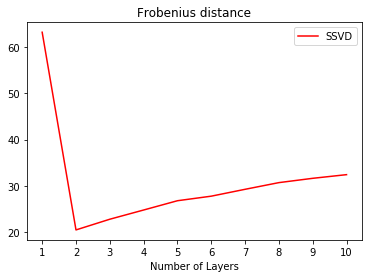

In [189]:
plt.plot(range(1, 11), f_dist, color='red', label='SSVD')
plt.legend()
plt.title('Frobenius distance')
plt.xlabel('Number of Layers')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.savefig('f-dist-ssvd.jpg')
plt.show()

In this case, the Sparse SVD algorithm gives the best approximation when the number of layers is 2. After the minimun point, this model starts to overfit the data.

## Applications to real datasets

The real datasets "Lung Cancer data" used in the paper could not be found. So we provide another example of the real-world data that's not in the paper. 

This dataset contains credit card transactions made by European cardholders in September 2013. Some of them are fraud transactions. For privacy reason, this dataset only has numerical inputs and we don't know exactly what each variable represents. 

For convenience, we subset only first 100 rows of records to make it as the test matrix $X$. The shape of $X$ is 100 by 28. Each row represents each record of transaction, while each column represents a feature. 

In [102]:
import pandas as pd

In [118]:
df_real = pd.read_csv("real_data.csv")
df = df_real.drop(['Time', 'Amount', 'Class'], axis = 1)[0:100]
X = np.array(df)
X.shape

(100, 28)

In [119]:
def svd(X):
    U, S, V = la.svd(X)
    return U[:, 0], V[0, :]

In [125]:
u = svd(X)[0].reshape(-1, 1)
u = np.round(u / la.norm(u), 1)
v = svd(X)[1].reshape(1, -1)
v = np.round(v / la.norm(v), 1)
X1_ = 28 * u @ v

In [127]:
np.count_nonzero(u)

67

In [128]:
np.count_nonzero(v)

15

In [129]:
num_zeros_u = []
cor_zeros_u = []
cor_non_zeros_u = []
mis_rate_u = []
num_zeros_v = []
cor_zeros_v = []
cor_non_zeros_v = []
mis_rate_v = []

np.random.seed(seed=0)
start = time()
iters = 100
with tqdm(total=iters) as pbar:
    for i in range(iters):
        X1 = X1_ + np.random.normal(size=(100, 28))
        u_new, v_new, s_new = ssvd_new(X1)
        
        num_zeros_u.append((u_new==0).sum())
        cor_zeros_u.append(np.logical_and(u_new.reshape(-1, 1)==0, u==0).sum()/33)
        cor_non_zeros_u.append(np.logical_and(u_new.reshape(-1, 1)!=0, u!=0).sum()/67)
        mis_rate_u.append(np.logical_xor(u_new.reshape(-1, 1)==0, u==0).sum()/100)
        
        num_zeros_v.append((v_new==0).sum())
        cor_zeros_v.append(np.logical_and(v_new.reshape(1, -1)==0, v==0).sum()/13)
        cor_non_zeros_v.append(np.logical_and(v_new.reshape(1, -1)!=0, v!=0).sum()/15)
        mis_rate_v.append(np.logical_xor(v_new.reshape(1, -1)==0, v==0).sum()/28)
        
        pbar.update(1)

print("Cost time: {:.2f}s per loop\n".format((time()-start)/iters))

avg = lambda x: sum(x)/iters

print("Number of zeros in u:", avg(num_zeros_u))
print("Correctly Labeled zero in u:", avg(cor_zeros_u))
print("Correctly Labeled non-zero in u:", avg(cor_non_zeros_u))
print("Misspecification in u:", avg(mis_rate_u), "\n")

print("Number of zeros in v:", avg(num_zeros_v))
print("Correctly Labeled zero in v:", avg(cor_zeros_v))
print("Correctly Labeled non-zero in v:", avg(cor_non_zeros_v))
print("Misspecification in v:", avg(mis_rate_v), "\n")

100%|██████████| 100/100 [09:14<00:00,  5.03s/it]

Cost time: 5.54s per loop

Number of zeros in u: 45.07
Correctly Labeled zero in u: 0.9739393939393933
Correctly Labeled non-zero in u: 0.8070149253731347
Misspecification in u: 0.13790000000000008 

Number of zeros in v: 15.55
Correctly Labeled zero in v: 0.9676923076923072
Correctly Labeled non-zero in v: 0.8019999999999993
Misspecification in v: 0.12107142857142858 



Following the same testing procedure as we did in rank-1 approximationn in the simulated datasets, we found that the performance is good, but not as good as what we have in the simulated datasets. The misspecification rates in u and v are about 0.14 and 0.12. We could see that this algorithm has a high accuracy of identifying 0 in both vectors. 

When there're more 0 in both u and v, then it looks that this algorithm has a better performance in terms of labeling non-zero elements. 

## Comparative analysis with competing algorithms

In this section, We compared Sparse SVD algorithm's performance in simulated datasets with two competing methods, which are SVD and Sparse PCA algorithm. 

### Case 1

### SPCA

In [132]:
def h(y, lambd):
    return y if abs(y) > lambd else 0

def spca(X, lambd=1, tol=1e-10, iters=10000):
    # shapes of X
    n = X.shape[0]
    d = X.shape[1]
    # find starting vectors
    U, S, V = la.svd(X)
    u_old = U[:, 0]
    v_old = V[0, :] * S[0]
    for i in range(iters):
        # update v
        v_new = np.zeros(d)
        for j in range(d):
            v_new[j] = h((X.T @ u_old)[j], lambd)
        u_new = (X @ v_new) / la.norm(X @ v_new)
        # check convergence
        if la.norm(u_new - u_old)<tol:
            break
        else:
            u_old = u_new
            v_old = v_new
    return u_new, v_new

In [133]:
u = np.array([10, 9, 8, 7, 6, 5, 4, 3]+[2]*17+[0]*75).reshape(-1, 1)
u = u / la.norm(u)
v = np.array([10, -10, 8, -8, 5, -5]+[3]*5+[-3]*5+[0]*34).reshape(1, -1)
v = v / la.norm(v)
X1_ = 50 * u @ v

In [137]:
num_zeros_u_spcav = []
cor_zeros_u_spcav = []
cor_non_zeros_u_spcav = []
mis_rate_u_spcav = []
num_zeros_v_spcav = []
cor_zeros_v_spcav = []
cor_non_zeros_v_spcav = []
mis_rate_v_spcav = []

iters=100
np.random.seed(2)

with tqdm(total=iters) as pbar:
    for i in range(iters):
        X1 = X1_ + np.random.normal(size=(100, 50))
        u_new, v_new = spca(X1, 5)
        
        num_zeros_u_spcav.append((u_new==0).sum())
        cor_zeros_u_spcav.append(np.logical_and(u_new.reshape(-1, 1)==0, u==0).sum()/75)
        cor_non_zeros_u_spcav.append(np.logical_and(u_new.reshape(-1, 1)!=0, u!=0).sum()/25)
        mis_rate_u_spcav.append(np.logical_xor(u_new.reshape(-1, 1)==0, u==0).sum()/100)
        
        num_zeros_v_spcav.append((v_new==0).sum())
        cor_zeros_v_spcav.append(np.logical_and(v_new.reshape(1, -1)==0, v==0).sum()/34)
        cor_non_zeros_v_spcav.append(np.logical_and(v_new.reshape(1, -1)!=0, v!=0).sum()/16)
        mis_rate_v_spcav.append(np.logical_xor(v_new.reshape(1, -1)==0, v==0).sum()/50)
        
        pbar.update(1)

print("Result of SPCA(v):")

avg = lambda x: sum(x)/iters

print("Number of zeros in u:", avg(num_zeros_u_spcav))
print("Correctly Labeled zero in u:", avg(cor_zeros_u_spcav))
print("Correctly Labeled non-zero in u:", avg(cor_non_zeros_u_spcav))
print("Misspecification in u:", avg(mis_rate_u_spcav), "\n")

print("Number of zeros in v:", avg(num_zeros_v_spcav))
print("Correctly Labeled zero in v:", avg(cor_zeros_v_spcav))
print("Correctly Labeled non-zero in v:", avg(cor_non_zeros_v_spcav))
print("Misspecification in v:", avg(mis_rate_v_spcav), "\n")

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 223.43it/s]


Result of SPCA(v):
Number of zeros in u: 0.0
Correctly Labeled zero in u: 0.0
Correctly Labeled non-zero in u: 1.0
Misspecification in u: 0.75 

Number of zeros in v: 34.28
Correctly Labeled zero in v: 1.0
Correctly Labeled non-zero in v: 0.9825
Misspecification in v: 0.005600000000000002 



In [138]:
num_zeros_u_spcau = []
cor_zeros_u_spcau = []
cor_non_zeros_u_spcau = []
mis_rate_u_spcau = []
num_zeros_v_spcau = []
cor_zeros_v_spcau = []
cor_non_zeros_v_spcau = []
mis_rate_v_spcau = []

np.random.seed(3)
iters=100

with tqdm(total=iters) as pbar:
    for i in range(iters):
        X1 = X1_ + np.random.normal(size=(100, 50))
        v_new, u_new = spca(X1.T, 3)
        
        num_zeros_u_spcau.append((u_new==0).sum())
        cor_zeros_u_spcau.append(np.logical_and(u_new.reshape(-1, 1)==0, u==0).sum()/75)
        cor_non_zeros_u_spcau.append(np.logical_and(u_new.reshape(-1, 1)!=0, u!=0).sum()/25)
        mis_rate_u_spcau.append(np.logical_xor(u_new.reshape(-1, 1)==0, u==0).sum()/100)
        
        num_zeros_v_spcau.append((v_new==0).sum())
        cor_zeros_v_spcau.append(np.logical_and(v_new.reshape(1, -1)==0, v==0).sum()/34)
        cor_non_zeros_v_spcau.append(np.logical_and(v_new.reshape(1, -1)!=0, v!=0).sum()/16)
        mis_rate_v_spcau.append(np.logical_xor(v_new.reshape(1, -1)==0, v==0).sum()/50)
        
        pbar.update(1)

print("Result of SPCA(u):")

avg = lambda x: sum(x)/iters

print("Number of zeros in u:", avg(num_zeros_u_spcau))
print("Correctly Labeled zero in u:", avg(cor_zeros_u_spcau))
print("Correctly Labeled non-zero in u:", avg(cor_non_zeros_u_spcau))
print("Misspecification in u:", avg(mis_rate_u_spcau), "\n")

print("Number of zeros in v:", avg(num_zeros_v_spcau))
print("Correctly Labeled zero in v:", avg(cor_zeros_v_spcau))
print("Correctly Labeled non-zero in v:", avg(cor_non_zeros_v_spcau))
print("Misspecification in v:", avg(mis_rate_v_spcau), "\n")

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 164.70it/s]


Result of SPCA(u):
Number of zeros in u: 75.58
Correctly Labeled zero in u: 0.996933333333333
Correctly Labeled non-zero in u: 0.9675999999999996
Misspecification in u: 0.010400000000000006 

Number of zeros in v: 0.0
Correctly Labeled zero in v: 0.0
Correctly Labeled non-zero in v: 1.0
Misspecification in v: 0.6800000000000002 



### SVD

In [139]:
def svd(X):
    U, S, V = la.svd(X)
    return U[:, 0], V[0, :]

In [140]:
num_zeros_u_svd = []
cor_zeros_u_svd = []
cor_non_zeros_u_svd = []
mis_rate_u_svd = []
num_zeros_v_svd = []
cor_zeros_v_svd = []
cor_non_zeros_v_svd = []
mis_rate_v_svd = []

iters=100

with tqdm(total=iters) as pbar:
    for i in range(iters):
        X1 = X1_ + np.random.normal(size=(100, 50))
        u_new, v_new = svd(X1)
        
        num_zeros_u_svd.append((u_new==0).sum())
        cor_zeros_u_svd.append(np.logical_and(u_new.reshape(-1, 1)==0, u==0).sum()/75)
        cor_non_zeros_u_svd.append(np.logical_and(u_new.reshape(-1, 1)!=0, u!=0).sum()/25)
        mis_rate_u_svd.append(np.logical_xor(u_new.reshape(-1, 1)==0, u==0).sum()/100)
        
        num_zeros_v_svd.append((v_new==0).sum())
        cor_zeros_v_svd.append(np.logical_and(v_new.reshape(1, -1)==0, v==0).sum()/34)
        cor_non_zeros_v_svd.append(np.logical_and(v_new.reshape(1, -1)!=0, v!=0).sum()/16)
        mis_rate_v_svd.append(np.logical_xor(v_new.reshape(1, -1)==0, v==0).sum()/50)
        
        pbar.update(1)

print("Result of SVD:")

avg = lambda x: sum(x)/iters

print("Number of zeros in u:", avg(num_zeros_u_svd))
print("Correctly Labeled zero in u:", avg(cor_zeros_u_svd))
print("Correctly Labeled non-zero in u:", avg(cor_non_zeros_u_svd))
print("Misspecification in u:", avg(mis_rate_u_svd), "\n")

print("Number of zeros in v:", avg(num_zeros_v_svd))
print("Correctly Labeled zero in v:", avg(cor_zeros_v_svd))
print("Correctly Labeled non-zero in v:", avg(cor_non_zeros_v_svd))
print("Misspecification in v:", avg(mis_rate_v_svd), "\n")

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 363.27it/s]


Result of SVD:
Number of zeros in u: 0.0
Correctly Labeled zero in u: 0.0
Correctly Labeled non-zero in u: 1.0
Misspecification in u: 0.75 

Number of zeros in v: 0.0
Correctly Labeled zero in v: 0.0
Correctly Labeled non-zero in v: 1.0
Misspecification in v: 0.6800000000000002 



| | |Avg.# of zeros(true)|Prop. of correctly identified zero|Prop. of correctly identified non-zero|misspecification rate|
|---|---|---|---|---|---|
|SSVD|u|72.87(75)|97.1%|96.5%|2.30%|
| |v|32.80(35)|99.7%|100.0%|2.40%|
|SPCA(u)|u|75.58(75)|99.7%|96.8%|1.04%|
| |v|0(35)|0.0%|100.0%|68%|
|SPCA(v)|u|0(75)|0.0%|100.0%|75%|
| |v|34.28(35)|100.0%|98.3%|0.56%|
|SVD|u|0(75)|0.0%|100.0%|75%|
| |v|0(35)|0.0%|100.0%|68%|

As one can see, SSVD performs much better than the competitors in all four metrics. The classic SVD can only identify non-zero entity without the ability to identify zero entities. For both SPCA(u) and SPCA(v), they can only demonstrate a compelling result in one dimension, either $u$ or $v$. And they perform poorly in the other dimension.

### Case 2

In [173]:
def spca_v_approx(X, lambd=1, layer=1):
    residual = X
    X_fit = np.zeros(X.shape)
    acc = []
    f_dist = []
    for i in range(layer):
        u_new, v_new = spca(residual, lambd)
        X_fit += u_new.reshape(-1, 1) @ v_new.reshape(1, -1)
        residual = X - X_fit
        acc.append(1 - np.logical_xor(X_fit == 0, X2_ == 0).sum()/(X.shape[0]*X.shape[1]))
        f_dist.append(np.sqrt(((X2_ - X_fit)**2).sum()))
        lambd = lambd/1.1
    return X_fit, acc, f_dist

def spca_u_approx(X, lambd=1, layer=1):
    residual = X
    X_fit = np.zeros(X.shape)
    acc = []
    f_dist = []
    for i in range(layer):
        v_new, u_new = spca(residual.T, lambd)
        X_fit += u_new.reshape(-1, 1) @ v_new.reshape(1, -1)
        residual = X - X_fit
        acc.append(1 - np.logical_xor(X_fit == 0, X2_ == 0).sum()/(X.shape[0]*X.shape[1]))
        f_dist.append(np.sqrt(((X2_ - X_fit)**2).sum()))
        lambd = lambd/1.1
    return X_fit, acc, f_dist

def svd_approx(X, layer=1):
    U, S, V = la.svd(X)
    acc = []
    f_dist = []
    for i in range(layer):
        if i == 0:
            X_fit = S[0] * U[:, 0].reshape(-1, 1) @ V[0, :].reshape(1, -1)
        else:
            X_fit = U[:, :(i+1)] @ np.diag(S[:(i+1)]) @ V[:(i+1), :]
        acc.append(1 - np.logical_xor(X_fit == 0, X2_ == 0).sum()/(X.shape[0]*X.shape[1]))
        f_dist.append(np.sqrt(((X2_ - X_fit)**2).sum()))
    return X_fit, acc, f_dist

In [174]:
np.random.seed(1)
X2 = X2_ + np.random.normal(size=(50, 100))
X_fit_v, acc_v, f_dist_v = spca_v_approx(X2, layer=10, lambd=5)
X_fit_u, acc_u, f_dist_u = spca_u_approx(X2, layer=10, lambd=3)
X_fit_svd, acc_svd, f_dist_svd = svd_approx(X2, layer=10)

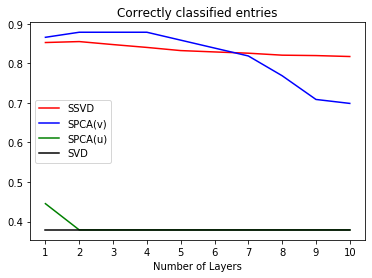

In [190]:
plt.plot(range(1, 11), acc, color='red', label='SSVD')
plt.plot(range(1, 11), acc_v, color='blue', label='SPCA(v)')
plt.plot(range(1, 11), acc_u, color='green', label='SPCA(u)')
plt.plot(range(1, 11), acc_svd, color='black', label='SVD')
plt.legend()
plt.title('Correctly classified entries')
plt.xlabel('Number of Layers')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.savefig('acc-all.jpg')
plt.show()

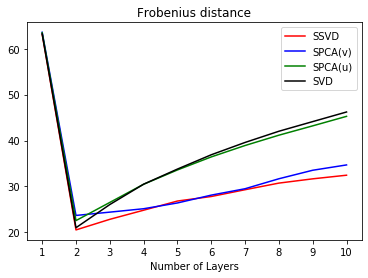

In [191]:
plt.plot(range(1, 11), f_dist, color='red', label='SSVD')
plt.plot(range(1, 11), f_dist_v, color='blue', label='SPCA(v)')
plt.plot(range(1, 11), f_dist_u, color='green', label='SPCA(u)')
plt.plot(range(1, 11), f_dist_svd, color='black', label='SVD')
plt.legend()
plt.title('Frobenius distance')
plt.xlabel('Number of Layers')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.savefig('f-dist-all.jpg')
plt.show()

In rank-2 case, SSVD and SPCA(u) performs well when classifying entities while SVD and SPCA(v) has trouble in detecting the sparse structure. Both SSVD and SPCA(u) arrive at maximum accuracy with 2 layers and start to overfit the data with more layers. The accuracy of SPCA(u) decreses rapidly after it exceeds 7 layers. With respect to Frobenius distance, all four methods perform well in approximating the true signal with minimum distance arrived at 2 layers. SSVD has the smallest distance with true signal. In conclusion, SSVD is the best option among these competing algorithms.